In [ ]:
!pip install wordninja

     |████████████████████████████████| 542kB 8.3MB/s 
  Created wheel for wordninja: filename=wordninja-2.0.0-cp36-none-any.whl size=541553 sha256=e166a96f83ecd6e40b4f7479f5624a70440afdcf6d7200f1fcb8d72a2cddbfe5
  Stored in directory: /root/.cache/pip/wheels/22/46/06/9b6d10ed02c85e93c3bb33ac50e2d368b2586248f192a2e22a
Successfully built wordninja


## Download stopwords dictionary of nltk library

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Import libraries

In [ ]:
import numpy as np
import time
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
import wordninja
import math
import scipy
import pickle

## Process data class

In [ ]:
class ProcessData:
    def __init__(self):
        '''
        Create stop words for URL
        '''
        self.stop_words = stopwords.words('english')
        url_stop_words = ['http', 'www', 'net', 'com', 'org',
                          'index', 'htm', 'html']
        self.stop_words += url_stop_words
        self.vectorizer = TfidfVectorizer()

    def read_csv(self, file_path: str) -> list:
        '''
        :param file_path: str
            file path of data file
        :return: list
            x_train, y_train, x_test, y_test
        '''
        df = pd.read_csv(file_path, names=['idx', 'URL', 'Category'])
        train, test = train_test_split(df, test_size=0.2)
        self.x_train = train['URL']
        self.y_train = train['Category'].astype('category').cat.codes.to_list()
        self.x_train = self.x_train.to_list()[:]
        self.x_test = test['URL']
        self.y_test = test['Category'].astype('category').cat.codes.to_list()
        self.x_test = self.x_test.to_list()[:]
        return self.x_train, self.y_train, self.x_test, self.y_test

    def tokenzier_url(self, url_list: list) -> list:
        '''
        Tokenize url by split special character
        :param url_list: list
            List of URL in dataset
        :return: list
            List of words after tokenize
        '''
        #tokenizer = RegexpTokenizer(r'\w+')
        tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')
        x_train_tokenized = []
        for x in url_list:
            try:
                x_tokenized = tokenizer.tokenize(x)
                x_tokenized = [w for w in x_tokenized if not w in self.stop_words]
                for word in x_tokenized:
                    word_split = wordninja.split(word)
                    x_tokenized = [w for w in word_split if (1 < len(w) < len(word))] + x_tokenized
                #print(x_tokenized)
                x_tokenized = " ".join(map(str, x_tokenized))
                x_train_tokenized.append(x_tokenized)
            except:
                x_train_tokenized.append('none')
                print(f"error at: {x}")
        return x_train_tokenized

    def vectorizer_url(self, x: list):
        '''
        Calculate tf-idf for training set
        :param x: list
            List of input URL
        :return: csr_matrix
            tf-idf of training set
        '''
        x_tokenized = self.tokenzier_url(x)
        x_tfidf = self.vectorizer.fit_transform(x_tokenized)
        print(x_tfidf.shape)
        return x_tfidf

    def vectorizer_url_test_set(self, x_test: list):
        '''
        calculate tf-idf for test set
        :param x_test: list
            List of input URL in test set
        :return: csr_matrix
            tf-idf of test set
        '''
        x_test_tokenized = self.tokenzier_url(x_test)
        x_test_tfidf = self.vectorizer.transform(x_test_tokenized)
        return x_test_tfidf

## MultinomialNB Class

In [ ]:
class MultinomialNB():
    def __init__(self, alpha: float = 1.0):
        '''
        Init for MultinomialNB class
        :param alpha: float
        '''
        self.alpha = alpha
        self.prior_prob = None
        self.num_class = None
        self.tfidf_count = None
        self.word_count = None

    def fit(self, x_train, y_train: np.ndarray):
        '''
        Fit trainning set to model
        :param x_train: csr_matrix
            Input of training set
        :param y_train: list
            Output of training set
        '''
        y_train = np.array(y_train)
        self.num_class = np.max(y_train) + 1
        self.prior_prob = self.calculate_prior_prob(y_train)
        self.calculate_tfidf_count(x_train, y_train)

    def calculate_prior_prob(self, y_train: np.ndarray) -> np.ndarray:
        '''
        Calculate prior probability for each class
        :param y_train: np.ndarray
            Output label of traning set
        :return: np.ndarray
            Prior probabilities for each class in training set
        '''
        self.prior_prob = [0]*self.num_class
        for i in range(self.num_class):
            mask = y_train == i
            count_mask = np.count_nonzero(mask)
            self.prior_prob[i] = count_mask
        self.prior_prob /= np.int32(len(y_train))
        return self.prior_prob

    def calculate_tfidf_count(self, x_train, y_train: np.ndarray):
        '''
        Calculate tf-idf count in training phase
        :param x_train: csr_matrix
            Input of training set
        :param y_train: np.ndarray
            Output of training set
        '''
        self.word_count = x_train.shape[1]
        self.tfidf_count = []
        for i in range(self.num_class):
            index_arr = np.where(y_train == i)
            count_sum = x_train[index_arr].sum()
            self.tfidf_count.append((np.array(x_train[index_arr].sum(axis=0)).squeeze() + self.alpha)/(count_sum + self.word_count))

    def predict(self, x_test) -> list:
        '''
        Predict output for test set
        :param x_test: csr_matrix
            Input of test set
        :return: list
            List of predicted classes
        '''
        y_pred = []
        for x in x_test:
            prob = [0] * self.num_class
            for i in range(self.num_class):
                probability = 1
                for j in range(len(x.data)):
                    probability *= self.tfidf_count[i][x.indices[j]]**x.data[j]
                prob[i] = math.log(probability*self.prior_prob[i])
            y_pred.append(np.argmax(prob))
        return y_pred

    def accuracy_score(self, y_test: list, y_pred: list) -> float:
        '''
        Calculate accuracy of model
        :param y_test: list
            Labels of test set
        :param y_pred:
            Predicted labels of model
        :return: float
            Accuracy of model
        '''
        return sum(np.equal(y_test, y_pred))/len(y_test)

## Read data from file

In [ ]:
#Initialize
FILE_PATH = "/content/drive/MyDrive/BAP Colab/URL Classification.csv"
process_data = ProcessData()

x_train, y_train, x_test, y_test = process_data.read_csv(FILE_PATH)

## Biểu đồ số lượng items trong tập training

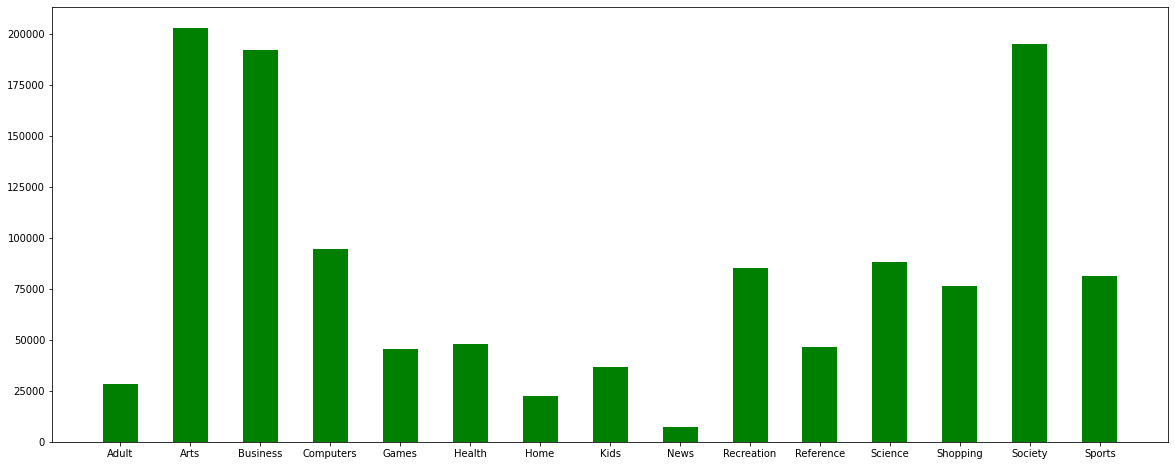

In [ ]:
labels = ['Adult', 'Arts', 'Business', 'Computers', 'Games', 'Health', 'Home', 'Kids',
          'News', 'Recreation', 'Reference', 'Science', 'Shopping', 'Society', 'Sports']
labels_count = np.unique(y_train, return_counts=True)
fig, ax = plt.subplots(figsize=(20, 8))
ax.bar(labels_count[0], labels_count[1], 0.5, tick_label=labels, color='green')
plt.show()

## Biểu đồ số lượng items trong tập test

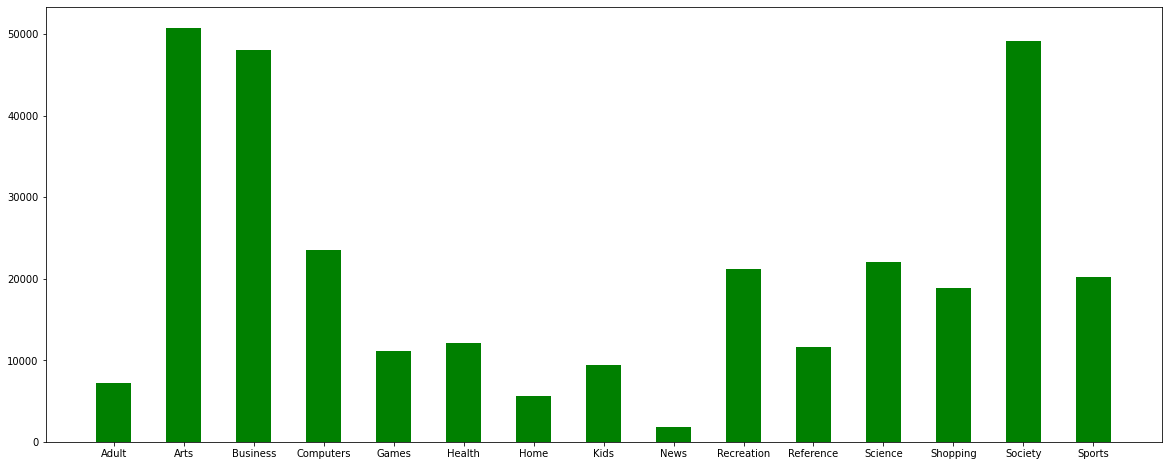

In [ ]:
labels_count = np.unique(y_test, return_counts=True)
fig, ax = plt.subplots(figsize=(20, 8))
ax.bar(labels_count[0], labels_count[1], 0.5, tick_label=labels, color='green')
plt.show()

## URL vectorizer using tf-idf

SAVED = False -> save to pickle file

SAVED = True -> load from pickle file

In [ ]:
SAVED = False
if SAVED == False:
    t1 = time.time()
    x_train_tfidf = process_data.vectorizer_url(x_train)
    t2 = time.time()
    print(f"time to run process_data.vectorizer_url= {t2 - t1}")
    with open("/content/drive/MyDrive/Colab Notebooks/vectorized_url.pickle", "wb") as handle:
        pickle.dump([process_data, x_train_tfidf], handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open("/content/drive/MyDrive/Colab Notebooks/vectorized_url.pickle", "rb") as handle:
        process_data, x_train_tfidf = pickle.load(handle)
    print('load successed from vectorized_url.pickle')

error at: nan
error at: nan
(1250382, 1052609)
time to run process_data.vectorizer_url= 188.44839668273926


## Vectorize for test set

In [ ]:
x_test_tfidf = process_data.vectorizer_url_test_set(x_test)
print(f"x_train_tfidf shape = {x_train_tfidf.shape}")
print(f"x_test_tfidf shape = {x_test_tfidf.shape}")

error at: nan
x_train_tfidf shape = (1250382, 1052609)
x_test_tfidf shape = (312596, 1052609)


## Fit data to train

In [ ]:
t1 = time.time()
clf = MultinomialNB(alpha=0.001)
clf.fit(x_train_tfidf, y_train)
t2 = time.time()
print(f"time to fit = {t2 - t1}")

time to fit = 0.6952095031738281


Ta có công thức:

\begin{equation}
P(C|X) \propto  P(C)\prod_{i=1}^{d} P(x_{i}|C)
\end{equation}

Trường hợp $P(x_{i}|C)$ nào đó bằng 0 hay cụ thể trong bài toán này thì một từ nào đó mới của tập test không xuất hiện trong một class nào đó của tập train dẫn đến xác suất bằng 0. Để giải quyết vấn đề này thì người ta thường sử dụng kỹ thuật smoothing ở đây cụ thể là laplace smoothing với hyperparameter là $\alpha$. 

Thường với các bài toàn sử dụng word count thì alpha thường bằng 1. Tuy nhiên ở bài toán này sử dụng tf-idf nên các giá trị trong vector thường bé hơn một vật nên em chọn qua một vài giá trị bé hơn một và khi chọn 0.001 thì thấy độ chính xác tốt nên lựa chọn $\alpha = 0.001$. 

Accuracy of Training Set

In [ ]:
t1 = time.time()
y_pred = clf.predict(x_train_tfidf)
accuracy = clf.accuracy_score(y_train, y_pred)
t2 = time.time()
print("accuracy of training set = ", accuracy)
print(f"time to predict = {t2 - t1}")

accuracy of training set =  0.8866658349208482
time to predict = 204.02721071243286


In [ ]:
print(metrics.classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.82      0.90     28173
           1       0.81      0.97      0.89    203065
           2       0.89      0.95      0.92    192118
           3       0.96      0.87      0.91     94447
           4       0.90      0.85      0.87     45369
           5       0.98      0.82      0.89     47982
           6       0.99      0.69      0.81     22670
           7       0.98      0.51      0.67     36723
           8       1.00      0.29      0.44      7186
           9       0.95      0.89      0.92     85365
          10       0.94      0.56      0.70     46631
          11       0.86      0.86      0.86     88283
          12       0.99      0.89      0.93     76410
          13       0.82      0.95      0.88    194816
          14       0.96      0.94      0.95     81144

    accuracy                           0.89   1250382
   macro avg       0.93      0.79      0.84   1250382
weighted avg       0.90   

## Confusion matrix of training set

color bar bên phải là thể hiển độ lớn của các giá trị trong confusion matrix. Giá trị còn lớn thì màu của nó càng đậm.

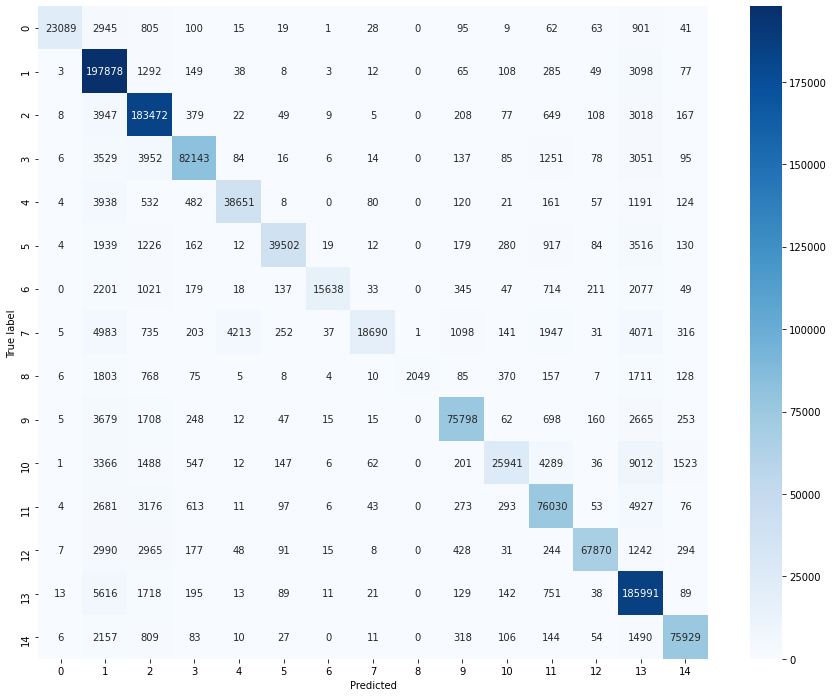

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_train, y_pred)
plt.figure(figsize=(15, 12))
sns.heatmap(np.array(confusion_matrix), fmt='d', annot=True, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True label")
plt.show()

## Accuracy of Testing Set

In [ ]:
t1 = time.time()
y_pred = clf.predict(x_test_tfidf)
accuracy = clf.accuracy_score(y_test, y_pred)
t2 = time.time()
print("accuracy of test set = ", accuracy)
print(f"time to predict = {t2 - t1}")

accuracy of test set =  0.5263663002725563
time to predict = 46.8449330329895


In [ ]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.47      0.63      7152
           1       0.44      0.79      0.56     50775
           2       0.48      0.63      0.55     48059
           3       0.71      0.39      0.50     23515
           4       0.73      0.46      0.56     11108
           5       0.80      0.32      0.46     12115
           6       0.86      0.34      0.48      5599
           7       0.45      0.15      0.22      9459
           8       0.53      0.03      0.05      1803
           9       0.65      0.33      0.44     21221
          10       0.61      0.19      0.29     11616
          11       0.61      0.52      0.56     22003
          12       0.58      0.14      0.23     18860
          13       0.48      0.70      0.57     49127
          14       0.80      0.55      0.65     20184

    accuracy                           0.53    312596
   macro avg       0.64      0.40      0.45    312596
weighted avg       0.58   

# Ý nghĩa của macro avg và weighted avg:

Macro-average precision là trung bình cộng của các precision theo class, tương tự với Macro-average recall và Macro-average F1-score:

\begin{equation}
macro-avg-precision = \frac{\sum_{c=1}^{N} precision}{N}
\end{equation}

*   Với N là số class trong tập dữ liệu. 
*   Ở trong bài toán URL Classification này N = 15.

Accuracy sẽ thể hiện không chính xác về độ chính xác của mô hình trong trường hợp tập training là tập dữ liệu mất cân bằng (imbalance dataset). Vậy nên chúng ta sẽ cần weighted average để đánh giá mô hình:

\begin{equation}
weighted-average-precision= \frac{\sum_{n=1}^{N} precision_{n} \times support_{n}}{m}
\end{equation}

*   Với $support_{n}$ là số samples của class thứ n
*   m là tất cả samples trong tập test

Các công thức để tính macro-avg và weighted-avg dành cho recall hay f1-score cũng được tính toán tương tự như tính cho precision.

## Confusion matrix of training set

Color bar bên phải là thể hiển độ lớn của các giá trị trong confusion matrix. Giá trị còn lớn thì màu của nó càng đậm.

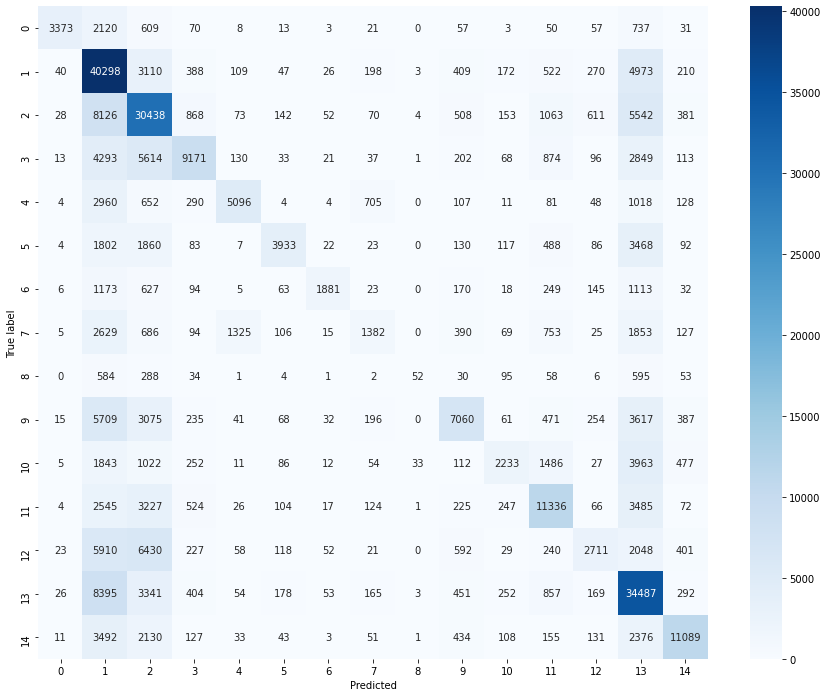

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(15, 12))
sns.heatmap(np.array(confusion_matrix), fmt='d', annot=True, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True label")
plt.show()

# Nhận xét với confusion matrix:

1.   Ở trên ta đã tính được độ chính xác của tập trainning đang lớn hơn rất nhiều so với độ chính xác của tập test do đó có thể kết luận được mô hình đang rơi vào trạng thái Overfitting.
2.   Đối với 2 confusion matrix ở trên ta có thể tính ra được precision đều lớn hơn recall và hầu như dự đoán các class có số lượng samples nhỏ nhầm vào các class có số lượng samples lớn.
3.   Tại sao chúng ta lại bị rơi vào vấn đề số 2 như vậy? Hãy nhìn vào hình bên dưới, đây là số lượng samples ở trong mỗi class của tập dữ liệu. Có thể thấy, đây là một tập dữ liệu hoàn toàn mất cân bằng, tuy nhiên đối với thuật toán Naive Bayes chúng ta cần nhân với "prior probabilites" là xác xuất của mỗi class trong tập huấn luyện. Vậy nên, đối với các class có số lượng sample lớn thì "prior probability" của class đó sẽ lớn và ngược lại. Vậy nên, trong quá trình testing ta sẽ dự đoán nhầm rất nhiều vào các class có số lượng sample lớn, dẫn đến quá trình testing sẽ cho ra độ chính xác rất thấp. Em đã có thử không nhân với "prior probabilities" thì độ chính xác của mô hình tăng lên khoảng 3% đến 6%, tuy nhiên theo lý thuyết của Naive Bayes thì ta cần nhân với đại lượng này. Bởi vì một vài lý do ở trên dẫn đến thuật toán này mang lại kết quả không tốt ở trong bài toán này.

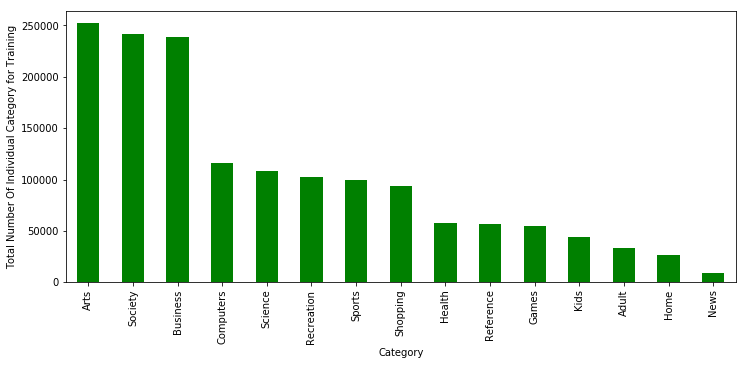





## Có thể bỏ prior probabilities được không?

Theo lý thuyết của Naive Bayes thì ta phải nhân với prior probabilities vì nó thể hiện cho sự trải nghiệm trước đây của việc "học".

Tuy nhiên, ở đây bài toán của chúng ta đang là bài toán phân loại, vậy nên ta cần thực hiện sao cho kết quả nhận dạng là tốt nhất. Vậy nên em nghĩ có thể bỏ được prior probabilities. Nhưng lúc này bài toán của chúng ta sẽ không tuân theo Naive Bayes nữa.

Một cách để giải quyết vấn đề này là chúng ta có thể chuẩn bị lại tập dữ liệu. Trong thực tế thì những link liên quan đến chủ đề "Arts" xảy ra ít hơn rất nhiều so với chủ đều "News", tuy nhiên trong tập dữ liệu này thì hoàn toàn ngược lại. Vậy nên, chúng ta có thể chuẩn bị một tập dữ liệu có tính cân bằng giữa các lớp, khi này chúng ta vẫn có kết quả phân loại tốt mà bài toán vẫn tuân theo Naive Bayes.

## Trích dẫn từ "Data Understanding and Preparation
Robert Nisbet Ph.D., ... Ken Yale D.D.S., J.D., in Handbook of Statistical Analysis and Data Mining Applications (Second Edition), 2018"

Prior Probabilities
The prior probability of a given target class is the proportion of its occurrence compared with the other target state. Some analytic algorithms permit the specification of prior probability (e.g., STATISTICA Data Miner classification and regression trees). These probabilities function in a manner similar to weights in controlling the effect of a case with a given target class on the final predicted value. If the modeling algorithm you choose has this capability, it might produce a more predictive model than with either sampling method.

Which method is best? The answer is it depends on your data. The safest course to follow is to test as many methods as you can on your data set and pick the one that produces the most acceptable model in terms of accuracy and generality.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Một số lý do dẫn đến Overfitting và phương án giải quyết:

Lý do dẫn đến overfitting:

* Thiếu dữ liệu training
* Mô hình học quá khớp với dữ liệu training dẫn đến kết quả không chính xác trong quá trình testing
* Dữ liệu training chứa quá nhiều nhiễu
* Những điểm bất thường trong tập dữ liệu không được loại bỏ mà vẫn đưa vào quá trình trainning

Các phương pháp để giải quyết overfitting:

* Tăng dữ liệu trainning hoặc sử dụng các kỹ thuật data augmentation để tăng dữ liệu
* Loại bỏ nhiễu hoặc các điểm bất thường trong tập dữ liệu
* Sử dụng kỹ thuật cross-validation
* Sử dụng một mô hình đơn giản hơn để học vừa đủ từ dữ liệu của tập training
* Nếu là các mô hình deep learning thì có thể sử dụng các kỹ thuật regularizer như: L2 regularizer, drop-out.
* Hoặc sử dụng kỹ thuật Early stopping để dừng quá trình huấn luyện khi đạt đến một độ chính xác nhất định (Deep Learning)